In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
%matplotlib inline
from tf_explain.core.activations import ExtractActivations



In [2]:
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 127.5

    return patched_image

In [33]:
model = tf.keras.models.load_model('../models/newMobileNet.h5')

In [157]:
img = '../static/test5.jpg'
def prepare_image(img):
        img = tf.keras.preprocessing.image.load_img(img, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        
        return img_array
    
img = prepare_image(img)

In [158]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

FileNotFoundError: [Errno 2] No such file or directory: 'static/output.png'

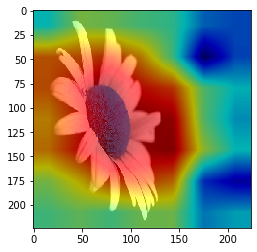

In [162]:
LAYER_NAME = 'Conv_1_bn'
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions

    
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]
weights = tf.reduce_mean(grads, axis=(0, 1))
cam = np.ones(output.shape[0:2], dtype=np.float32)
for index, w in enumerate(weights):
    cam += w * output[:, :, index]

cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 0.7, 0)


plt.imsave('static/output.png', output_image)